In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [2]:
# Visualization helpers
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev

In [3]:
# for pipelined data
import emeval.analysed.phone_view as eapv

In [4]:
import pandas as pd

In [5]:
import geopandas as gpd
import shapely as shp
import shapely.geometry as shpgeo

In [6]:
import emeval.viz.geojson as ezgj

In [7]:
import numpy as np

In [8]:
import emeval.metrics.dist_calculations as emd

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [9]:
# For plots
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Analytics results
import emeval.metrics.segmentation as ems

In [11]:
# for statistics
import scipy as sp
import scipy.stats as spst 

In [12]:
# For easier debugging while working on modules
import importlib

In [13]:
import sys 

In [14]:
sys.path.append('/Users/kshankar/e-mission/gis_branch_tests')

In [15]:
import emeval.analysed.location_smoothing as eaicl

In [16]:
# json
import json

In [17]:
DATASTORE_LOC = "bin/data"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sd_la = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "unimodal_trip_car_bike_mtv_la")
sd_sj = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "car_scooter_brex_san_jose")
sd_ucb = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "train_bus_ebike_mtv_ucb")

After iterating over 1 entries, entry found
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multi-modal car scooter BREX trip to San Jose
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2020-04-30T00:00:00-07:00


In [18]:
pv_la = eipv.PhoneView(sd_la)
pv_sj = eipv.PhoneView(sd_sj)
pv_ucb = eipv.PhoneView(sd_ucb)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
Loading transitions for phone ucb-sdb-android-2
Loading transitions for phone ucb-sdb-android-3
Loading transitions for phone ucb-sdb-android-4
Reading data for ios phones
Loading transitions for phone ucb-sdb-ios-1
Loading transitions for phone ucb-sdb-ios-2
Loading transitions for phone ucb-sdb-ios-3
Loading transitions for phone ucb-sdb-ios-4
-------------------- About to fill calibration ranges --------------------
Processing data for android phones
Processing transitions for phone ucb-sdb-android-1
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-2
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-3
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-4
Filtered 86 total -> 0 calibration

In [19]:
%%capture
ems.fill_sensed_section_ranges(pv_la)
ems.fill_sensed_section_ranges(pv_sj)
ems.fill_sensed_section_ranges(pv_ucb)

In [20]:
import copy

In [21]:
MASTER_DATA_LOC = "bin/data/master_9b70c97"
master_spec = eisd.FileSpecDetails(MASTER_DATA_LOC, AUTHOR_EMAIL)

In [22]:
av_la = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
av_sj = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
av_ucb = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

In [23]:
def get_ss_and_gts_dists(pv_l, os, role):
    if type(pv_l) is not list:
        pv_l = [pv_l]
    trip_dists = []
    for pv in pv_l:
        for phone_os, phone_map in pv.map().items():
            if os != phone_os: continue
            for phone_label, phone_detail_map in phone_map.items():
                for r in phone_detail_map["evaluation_ranges"]:
                    if role not in r['eval_role']: continue
                    if 'control' in r['eval_role']: continue
                    run_ss_dist, run_gt_dist = 0,0
                    for i, tr in enumerate(r["evaluation_trip_ranges"]):
                        sensed_dist, gt_dist = 0,0
                        for ss in tr['sensed_section_ranges']:
                            if 'data' in ss.keys():
                                if i > 0: assert ss['data']['start_ts'] > r["evaluation_trip_ranges"][i-1]['end_ts']
                                if i > 0: assert ss['data']['start_ts'] > trip_dists[-1]['gt_end_ts']
                                sensed_dist += ss['data']['distance']
#                                 print(ss['data']['sensed_mode'], ss['data']['start_ts'], ss['data']['end_ts'])
                            else:
                                sensed_dist = eaicl.add_dist( tr['location_df'] ).distance.sum()
                                break
                        try:
                            sensed_dist = sensed_dist[0]
                        except:
                            pass
                        print('sensed dist', '\t', sensed_dist)
                        run_ss_dist += sensed_dist
                        for sr in tr['evaluation_section_ranges']:
                            ##### Ground Truth Distance ######
                            gt_leg = pv.spec_details.get_ground_truth_for_leg(
                                tr["trip_id_base"], 
                                sr["trip_id_base"], 
                                tr['start_ts'], 
                                tr['end_ts']
                            )
                            gt_shapes = gpd.GeoSeries(eisd.SpecDetails.get_shapes_for_leg(gt_leg))
                            if len(gt_shapes) <= 1:
                                continue
                            ## GET THE TOTAL GT DISTANCE OF A SECTION
                            gt_linestring = gt_shapes['route']
                            gt_geo_df = emd.linestring_to_geo_df(gt_linestring)
                            gt_loc_df = emd.to_loc_df(gt_geo_df)
                            gt_loc_with_dist_df =  eaicl.add_dist( gt_loc_df )
                            gt_dist += gt_loc_with_dist_df['distance'].sum()
#                             print(gt_leg['id'], sr['start_ts'], sr['end_ts'])
                        print('gt_dist', '\t', gt_dist)
                        run_gt_dist += gt_dist
#                         print('sensed distance \t', sensed_dist)
#                         print('ground truth distance \t', gt_dist)
                        trip_dists.append(
                            {
                                'sensed_distance' : sensed_dist,
                                'ground_truth_distance' : gt_dist,
                                'gt_end_ts' : tr['evaluation_section_ranges'][-1]['end_ts']
                            }
                        )
#                     print('run sensed distance \t', run_ss_dist)
#                     print('run ground truth dist \t', run_gt_dist)
#                     print(f"trip: \t{tr['trip_id']} \n os: \t{phone_os}",'\n \n')
    return trip_dists

In [24]:
import importlib
importlib.reload(eaicl)

<module 'emeval.analysed.location_smoothing' from '/Users/kshankar/e-mission/mobilitynet-analysis-scripts/emeval/analysed/location_smoothing.py'>

In [25]:
get_ss_and_gts_dists([av_la, av_sj, av_ucb], 'ios', 'HAMFDC')

sensed dist 	 3194.8884742511723
gt_dist 	 4166.48087694807
sensed dist 	 3255.1545958988327
gt_dist 	 3575.1150980810125
sensed dist 	 142.81924916129435
gt_dist 	 4166.48087694807
sensed dist 	 3233.7047883770024
gt_dist 	 3575.1150980810125
sensed dist 	 3211.6702886497974
gt_dist 	 4166.48087694807
sensed dist 	 3152.737977860821
gt_dist 	 3575.1150980810125
sensed dist 	 20889.849770984558
gt_dist 	 21897.56145035604
sensed dist 	 20910.154681505075
gt_dist 	 21743.642376215947
sensed dist 	 19716.58170232863
gt_dist 	 21897.56145035604
sensed dist 	 20619.926024572178
gt_dist 	 21743.642376215947
sensed dist 	 16019.31638205737
gt_dist 	 21897.56145035604
sensed dist 	 20941.35996867296
gt_dist 	 21743.642376215947
sensed dist 	 81620.16614269682
gt_dist 	 86033.02062489765
sensed dist 	 707.8006652449207
gt_dist 	 837.9847664440726
sensed dist 	 82555.814442197
gt_dist 	 84509.67456654109
sensed dist 	 80360.99705238681
gt_dist 	 86033.02062489765
sensed dist 	 866.8708668866533

[{'sensed_distance': 3194.8884742511723,
  'ground_truth_distance': 4166.48087694807,
  'gt_end_ts': 1565572029.659311},
 {'sensed_distance': 3255.1545958988327,
  'ground_truth_distance': 3575.1150980810125,
  'gt_end_ts': 1565577104.662489},
 {'sensed_distance': 142.81924916129435,
  'ground_truth_distance': 4166.48087694807,
  'gt_end_ts': 1567272188.458191},
 {'sensed_distance': 3233.7047883770024,
  'ground_truth_distance': 3575.1150980810125,
  'gt_end_ts': 1567277558.7505531},
 {'sensed_distance': 3211.6702886497974,
  'ground_truth_distance': 4166.48087694807,
  'gt_end_ts': 1567289688.778185},
 {'sensed_distance': 3152.737977860821,
  'ground_truth_distance': 3575.1150980810125,
  'gt_end_ts': 1567295493.7019649},
 {'sensed_distance': 20889.849770984558,
  'ground_truth_distance': 21897.56145035604,
  'gt_end_ts': 1565027779.040153},
 {'sensed_distance': 20910.154681505075,
  'ground_truth_distance': 21743.642376215947,
  'gt_end_ts': 1565047154.3463578},
 {'sensed_distance': 

#### First, we find the overall approximation errors

In [26]:
def get_approx_err(os, role, pv_l):
    trip_dist = get_ss_and_gts_dists(pv_l, os, role)
    relative_error = []
    absolute_error = []
    for i in range(len(trip_dist)):
        abs_err = (trip_dist[i]['sensed_distance'] - trip_dist[i]['ground_truth_distance'])
        rel_err = abs_err / trip_dist[i]['ground_truth_distance']
        relative_error.append(rel_err)
        absolute_error.append(abs_err)
    relative_error_df = pd.DataFrame(relative_error)
    absolute_error_df =  pd.DataFrame(absolute_error)
    return absolute_error_df, relative_error_df

In [27]:
def get_describe_table(os, pv_l):
    dic = {}
    df = None
    err_df = None
    for role in ['HAHFDC', 'HAMFDC', 'MAHFDC']:
        a_err, r_err = get_approx_err(os, role, pv_l)
        if df is None:
            df = r_err.rename(columns={0: f"{role}"}).describe()
            err_df = r_err.rename(columns={0: f"{role}"})
        else:
            df = pd.concat([df, r_err.rename(columns={0: f"{role}"}).describe()], axis=1)
            err_df = pd.concat([err_df, r_err.rename(columns={0: f"{role}"})], axis=1)
    dic[os] = df
    err_df.plot.density(title=f'Gaussian KDE of Relative Error for {os}')
    err_df.plot.box(title=f'Box Plots of Relative Error for {os}')
    return pd.concat(dic, axis=1)

# Production Level Box Plots for Select Settings

In [28]:
def box_selected():
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=300, sharey=False)
    fig.text(0.06, 0.5, 'Signed Relative Error', va='center', rotation='vertical')
    for i, pv_l in enumerate([[pv_la, pv_sj, pv_ucb], [av_la, av_sj, av_ucb]]):
        a_err, r_err_and = get_approx_err('android', 'HAMFDC', pv_l)
        a_err, r_err_ios = get_approx_err('ios', 'HAHFDC', pv_l)
        err_df = pd.concat(
            [
                r_err_and.rename(columns={0 : 'andoird:HAMFDC'}),
                r_err_ios.rename(columns={0 : 'ios:HAHFDC'})
            ], axis=1
        )
        if i == 0:
            title = 'naive'
        else:
            title = 'clean'
        err_df.plot.box(title=title, ax=ax[i])
    plt.savefig(fname=f'images/rel_err_box_selected',  bbox_inches="tight")

sensed dist 	 2827.8701121814565
gt_dist 	 4166.48087694807
sensed dist 	 3030.6151916714052
gt_dist 	 3575.1150980810125
sensed dist 	 4778.326292657007
gt_dist 	 4166.48087694807
sensed dist 	 3188.8781787654348
gt_dist 	 3575.1150980810125
sensed dist 	 3937.542917188466
gt_dist 	 4166.48087694807
sensed dist 	 3441.6586026446653
gt_dist 	 3575.1150980810125
sensed dist 	 21422.252399929144
gt_dist 	 21897.56145035604
sensed dist 	 23005.146343828746
gt_dist 	 21743.642376215947
sensed dist 	 21893.875118037653
gt_dist 	 21897.56145035604
sensed dist 	 23091.28972163153
gt_dist 	 21743.642376215947
sensed dist 	 22417.076331444856
gt_dist 	 21897.56145035604
sensed dist 	 22359.709392942183
gt_dist 	 21743.642376215947
sensed dist 	 22271.338701095403
gt_dist 	 21897.56145035604
sensed dist 	 23518.194439752508
gt_dist 	 21743.642376215947
sensed dist 	 273832.48400787555
gt_dist 	 86033.02062489765
sensed dist 	 755.3680217742514
gt_dist 	 837.9847664440726
sensed dist 	 91047.1892

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


gt_dist 	 21743.642376215947
sensed dist 	 22080.469641041207
gt_dist 	 21897.56145035604
sensed dist 	 21428.75286250791
gt_dist 	 21743.642376215947
sensed dist 	 21138.673198129756
gt_dist 	 21897.56145035604
sensed dist 	 21604.17270806909
gt_dist 	 21743.642376215947
sensed dist 	 84198.03260421066
gt_dist 	 86033.02062489765
sensed dist 	 778.7739270588829
gt_dist 	 837.9847664440726
sensed dist 	 83812.87271054144
gt_dist 	 84509.67456654109
sensed dist 	 62147.263007374386
gt_dist 	 86033.02062489765
sensed dist 	 767.2502031845265
gt_dist 	 837.9847664440726
sensed dist 	 82475.18837377561
gt_dist 	 84509.67456654109
sensed dist 	 67147.69336275937
gt_dist 	 86033.02062489765
sensed dist 	 826.8963886546182
gt_dist 	 837.9847664440726
sensed dist 	 83649.70194680445
gt_dist 	 84509.67456654109
sensed dist 	 69745.27376276808
gt_dist 	 86033.02062489765
sensed dist 	 809.7893365417856
gt_dist 	 837.9847664440726
sensed dist 	 83878.84587318277
gt_dist 	 84509.67456654109
sensed

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


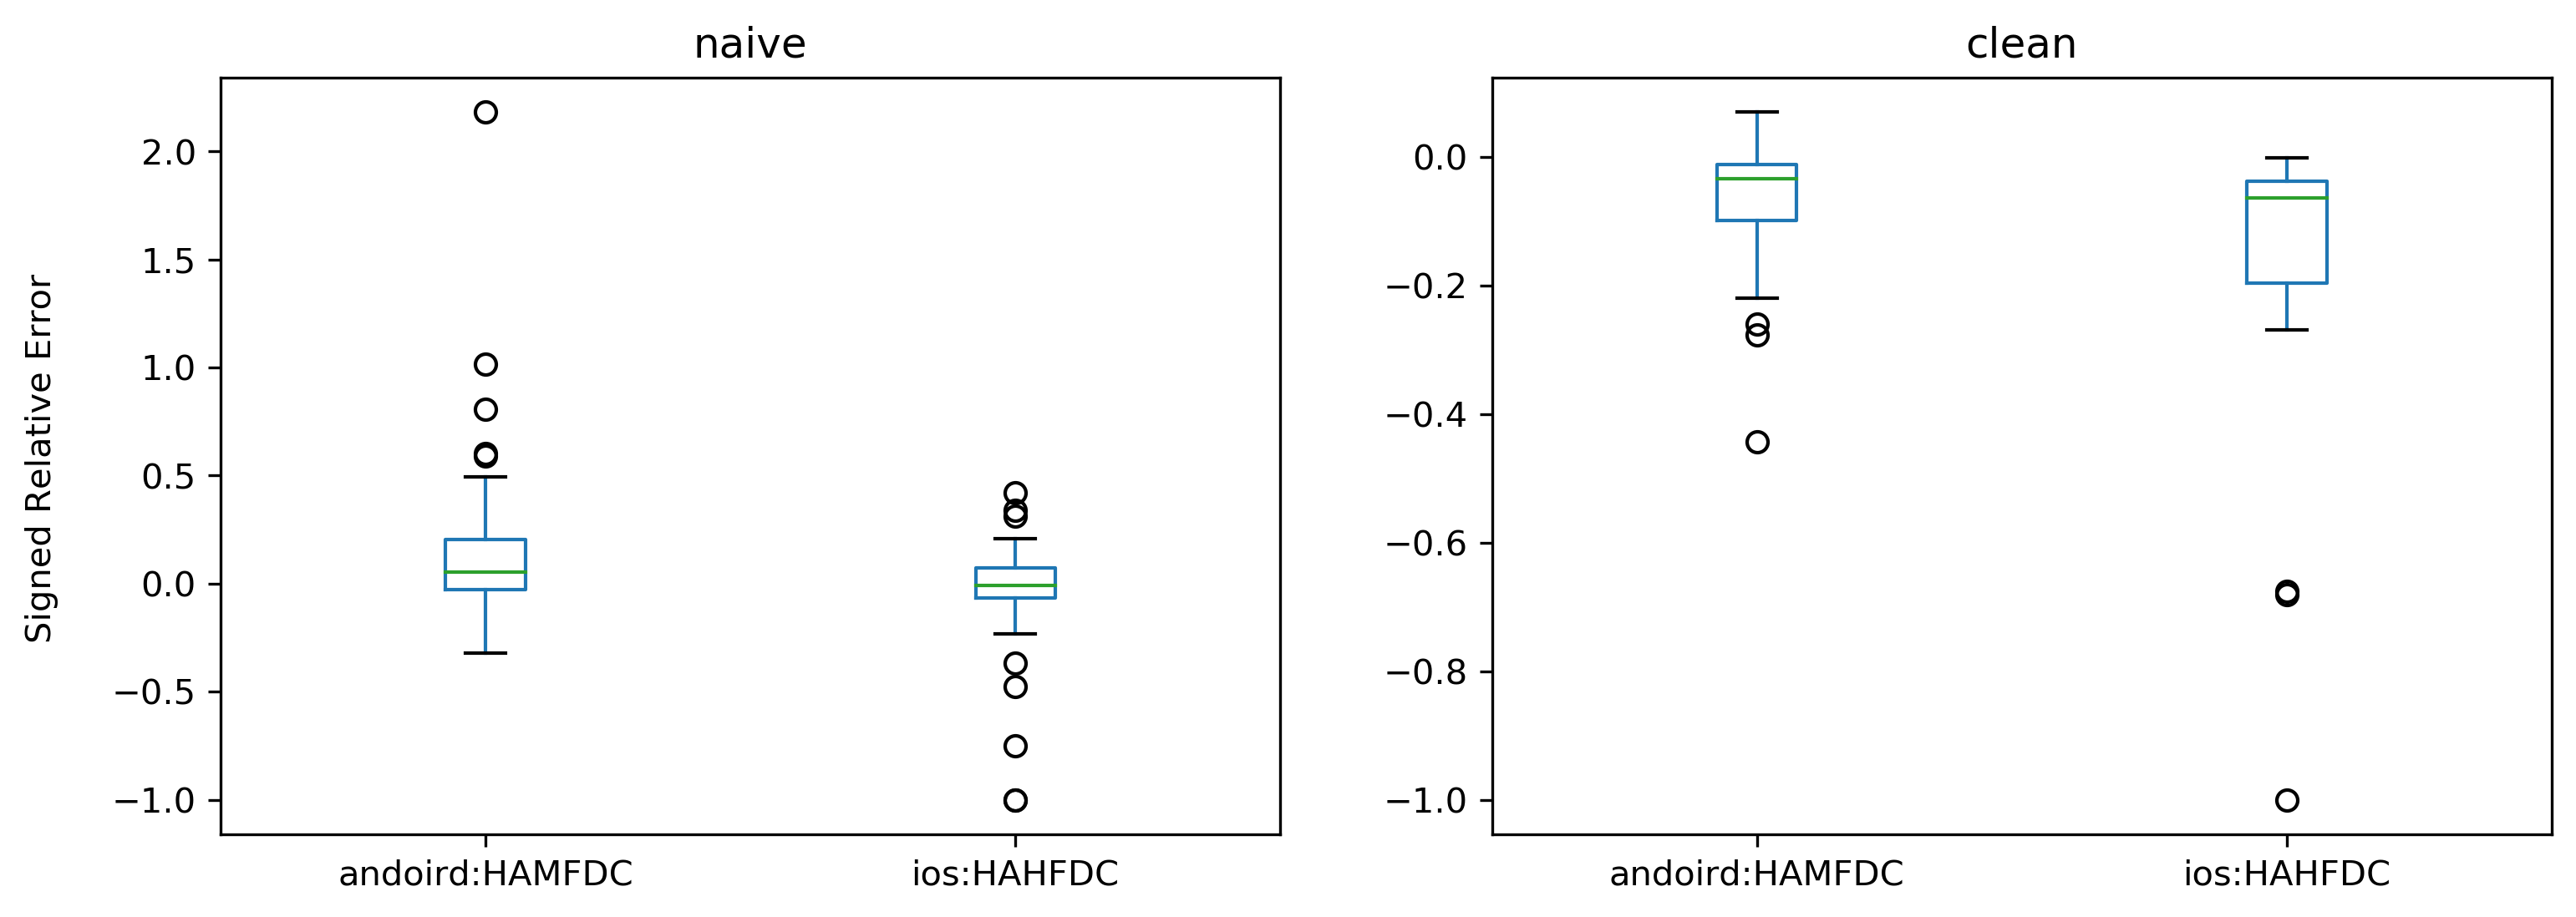

In [29]:
box_selected();

## Results

In [30]:
2.811445**2

7.9042229880249995

sensed dist 	 4775.5441108964105
gt_dist 	 4166.48087694807
sensed dist 	 3515.1767444849497
gt_dist 	 3575.1150980810125
sensed dist 	 4054.8434935926584
gt_dist 	 4166.48087694807
sensed dist 	 2786.6041759311906
gt_dist 	 3575.1150980810125
sensed dist 	 3914.3100522804407
gt_dist 	 4166.48087694807
sensed dist 	 3610.57194727899
gt_dist 	 3575.1150980810125
sensed dist 	 4368.545835068335
gt_dist 	 4166.48087694807
sensed dist 	 3566.217753951324
gt_dist 	 3575.1150980810125
sensed dist 	 3719.626672868246
gt_dist 	 4166.48087694807
sensed dist 	 3716.4972124798437
gt_dist 	 3575.1150980810125
sensed dist 	 5468.297678887172
gt_dist 	 4166.48087694807
sensed dist 	 3685.3462041627536
gt_dist 	 3575.1150980810125
sensed dist 	 21891.365706715853
gt_dist 	 21897.56145035604
sensed dist 	 22572.82712671218
gt_dist 	 21743.642376215947
sensed dist 	 21535.297050938338
gt_dist 	 21897.56145035604
sensed dist 	 24360.87190715653
gt_dist 	 21743.642376215947
sensed dist 	 22143.3268475854

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


android                      
          HAHFDC     HAMFDC     MAHFDC
count  42.000000  32.000000  30.000000
mean    0.814695   0.197191   2.187366
std     2.811445   0.466076   3.904016
min    -0.289444  -0.321281  -0.010076
25%    -0.008158  -0.025612   0.045589
50%     0.043870   0.055145   0.663483
75%     0.273433   0.204142   1.925149
max    16.253421   2.182877  18.023836

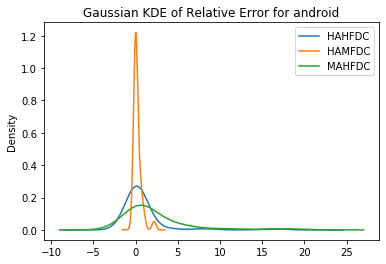

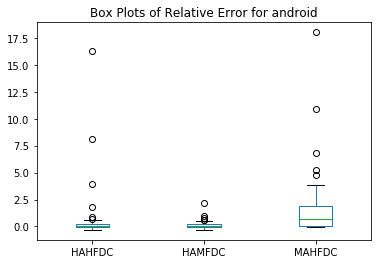

In [31]:
get_describe_table('android', [pv_la, pv_sj, pv_ucb])

In [32]:
0.291166**2

0.08477763955599998

sensed dist 	 2632.072480581079
gt_dist 	 4166.48087694807
sensed dist 	 3478.2096418463243
gt_dist 	 3575.1150980810125
sensed dist 	 3589.231177282194
gt_dist 	 4166.48087694807
sensed dist 	 3447.859633153888
gt_dist 	 3575.1150980810125
sensed dist 	 3582.6980435204946
gt_dist 	 4166.48087694807
sensed dist 	 3442.7083249721554
gt_dist 	 3575.1150980810125
sensed dist 	 4184.484500780401
gt_dist 	 4166.48087694807
sensed dist 	 3393.0584053113903
gt_dist 	 3575.1150980810125
sensed dist 	 0
gt_dist 	 4166.48087694807
sensed dist 	 889.0649736118582
gt_dist 	 3575.1150980810125
sensed dist 	 4507.758898258115
gt_dist 	 4166.48087694807
sensed dist 	 3316.26103595633
gt_dist 	 3575.1150980810125
sensed dist 	 22096.418998254092
gt_dist 	 21897.56145035604
sensed dist 	 22558.692049912446
gt_dist 	 21743.642376215947
sensed dist 	 21803.46326267333
gt_dist 	 21897.56145035604
sensed dist 	 20859.224825886115
gt_dist 	 21743.642376215947
sensed dist 	 21041.130758275736
gt_dist 	 21897

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ios                      
          HAHFDC     HAMFDC     MAHFDC
count  42.000000  30.000000  32.000000
mean   -0.060844  -0.072796   0.146142
std     0.291166   0.236490   0.509717
min    -1.000000  -0.944247  -1.000000
25%    -0.067034  -0.121293   0.161477
50%    -0.006930  -0.022144   0.241444
75%     0.071696   0.021319   0.353853
max     0.419181   0.259526   1.239151

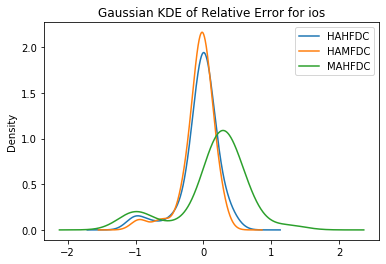

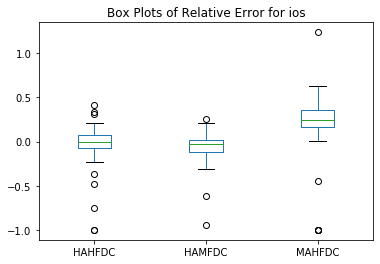

In [33]:
get_describe_table('ios', [pv_la, pv_sj, pv_ucb])

### cleaned output

In [34]:
0.156445**2

0.024475038025

sensed dist 	 3503.775161928929
gt_dist 	 4166.48087694807
sensed dist 	 3301.7577319788015
gt_dist 	 3575.1150980810125
sensed dist 	 3410.443543637887
gt_dist 	 4166.48087694807
sensed dist 	 2115.5380990388194
gt_dist 	 3575.1150980810125
sensed dist 	 3117.2259084359985
gt_dist 	 4166.48087694807
sensed dist 	 3433.183736399884
gt_dist 	 3575.1150980810125
sensed dist 	 3884.424739784956
gt_dist 	 4166.48087694807
sensed dist 	 3380.711149512784
gt_dist 	 3575.1150980810125
sensed dist 	 3144.043645648622
gt_dist 	 4166.48087694807
sensed dist 	 3483.613477096663
gt_dist 	 3575.1150980810125
sensed dist 	 3430.8687548988237
gt_dist 	 4166.48087694807
sensed dist 	 3301.925094952217
gt_dist 	 3575.1150980810125
sensed dist 	 21368.70141148622
gt_dist 	 21897.56145035604
sensed dist 	 21279.98973808508
gt_dist 	 21743.642376215947
sensed dist 	 20909.28994742663
gt_dist 	 21897.56145035604
sensed dist 	 21177.14870672462
gt_dist 	 21743.642376215947
sensed dist 	 21192.7616026213
gt_

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


android                      
          HAHFDC     HAMFDC     MAHFDC
count  42.000000  32.000000  30.000000
mean   -0.088811  -0.077655   0.035330
std     0.201912   0.105103   0.165414
min    -0.623847  -0.443385  -0.185002
25%    -0.172180  -0.098720  -0.048403
50%    -0.054645  -0.034151  -0.019528
75%    -0.025709  -0.012468   0.112414
max     0.788278   0.069560   0.425631

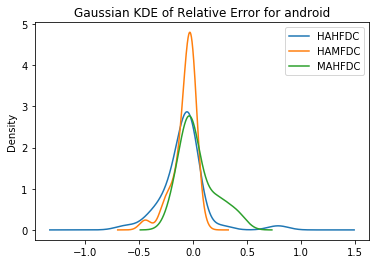

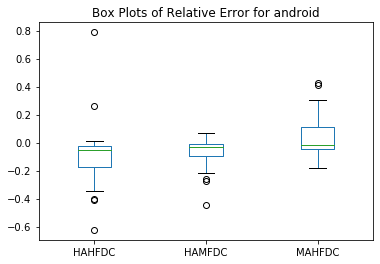

In [35]:
get_describe_table('android', [av_la, av_sj, av_ucb])

In [36]:
0.291166**2

0.08477763955599998

sensed dist 	 1327.3821915797214
gt_dist 	 4166.48087694807
sensed dist 	 3346.675191383114
gt_dist 	 3575.1150980810125
sensed dist 	 3260.6242535073716
gt_dist 	 4166.48087694807
sensed dist 	 3411.2825526163015
gt_dist 	 3575.1150980810125
sensed dist 	 3042.9788435548785
gt_dist 	 4166.48087694807
sensed dist 	 3408.270632169631
gt_dist 	 3575.1150980810125
sensed dist 	 3252.2093368207043
gt_dist 	 4166.48087694807
sensed dist 	 3443.574423915147
gt_dist 	 3575.1150980810125
sensed dist 	 0
gt_dist 	 4166.48087694807
sensed dist 	 1159.5156249085096
gt_dist 	 3575.1150980810125
sensed dist 	 3681.2378788387564
gt_dist 	 4166.48087694807
sensed dist 	 3384.6555189293344
gt_dist 	 3575.1150980810125
sensed dist 	 20965.415420205423
gt_dist 	 21897.56145035604
sensed dist 	 21707.186727826043
gt_dist 	 21743.642376215947
sensed dist 	 21023.111461033182
gt_dist 	 21897.56145035604
sensed dist 	 19450.075420969297
gt_dist 	 21743.642376215947
sensed dist 	 20252.52657979462
gt_dist 	 

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ios                      
          HAHFDC     HAMFDC     MAHFDC
count  42.000000  30.000000  32.000000
mean   -0.139719  -0.132806  -0.057539
std     0.201838   0.174396   0.208987
min    -1.000000  -0.965722  -1.000000
25%    -0.196637  -0.151218  -0.086618
50%    -0.064276  -0.089190  -0.025469
75%    -0.037578  -0.047338   0.013971
max    -0.001677   0.034471   0.300431

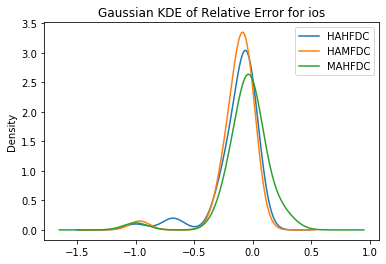

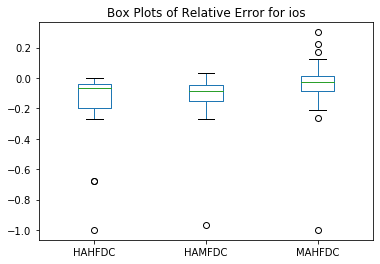

In [37]:
get_describe_table('ios', [av_la, av_sj, av_ucb])

sensed dist 	 2827.8701121814565
gt_dist 	 4166.48087694807
sensed dist 	 3030.6151916714052
gt_dist 	 3575.1150980810125
sensed dist 	 4778.326292657007
gt_dist 	 4166.48087694807
sensed dist 	 3188.8781787654348
gt_dist 	 3575.1150980810125
sensed dist 	 3937.542917188466
gt_dist 	 4166.48087694807
sensed dist 	 3441.6586026446653
gt_dist 	 3575.1150980810125
sensed dist 	 21422.252399929144
gt_dist 	 21897.56145035604
sensed dist 	 23005.146343828746
gt_dist 	 21743.642376215947
sensed dist 	 21893.875118037653
gt_dist 	 21897.56145035604
sensed dist 	 23091.28972163153
gt_dist 	 21743.642376215947
sensed dist 	 22417.076331444856
gt_dist 	 21897.56145035604
sensed dist 	 22359.709392942183
gt_dist 	 21743.642376215947
sensed dist 	 22271.338701095403
gt_dist 	 21897.56145035604
sensed dist 	 23518.194439752508
gt_dist 	 21743.642376215947
sensed dist 	 273832.48400787555
gt_dist 	 86033.02062489765
sensed dist 	 755.3680217742514
gt_dist 	 837.9847664440726
sensed dist 	 91047.1892

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


gt_dist 	 21743.642376215947
sensed dist 	 22080.469641041207
gt_dist 	 21897.56145035604
sensed dist 	 21428.75286250791
gt_dist 	 21743.642376215947
sensed dist 	 21138.673198129756
gt_dist 	 21897.56145035604
sensed dist 	 21604.17270806909
gt_dist 	 21743.642376215947
sensed dist 	 84198.03260421066
gt_dist 	 86033.02062489765
sensed dist 	 778.7739270588829
gt_dist 	 837.9847664440726
sensed dist 	 83812.87271054144
gt_dist 	 84509.67456654109
sensed dist 	 62147.263007374386
gt_dist 	 86033.02062489765
sensed dist 	 767.2502031845265
gt_dist 	 837.9847664440726
sensed dist 	 82475.18837377561
gt_dist 	 84509.67456654109
sensed dist 	 67147.69336275937
gt_dist 	 86033.02062489765
sensed dist 	 826.8963886546182
gt_dist 	 837.9847664440726
sensed dist 	 83649.70194680445
gt_dist 	 84509.67456654109
sensed dist 	 69745.27376276808
gt_dist 	 86033.02062489765
sensed dist 	 809.7893365417856
gt_dist 	 837.9847664440726
sensed dist 	 83878.84587318277
gt_dist 	 84509.67456654109
sensed

/Users/kshankar/miniconda-4.8.3/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


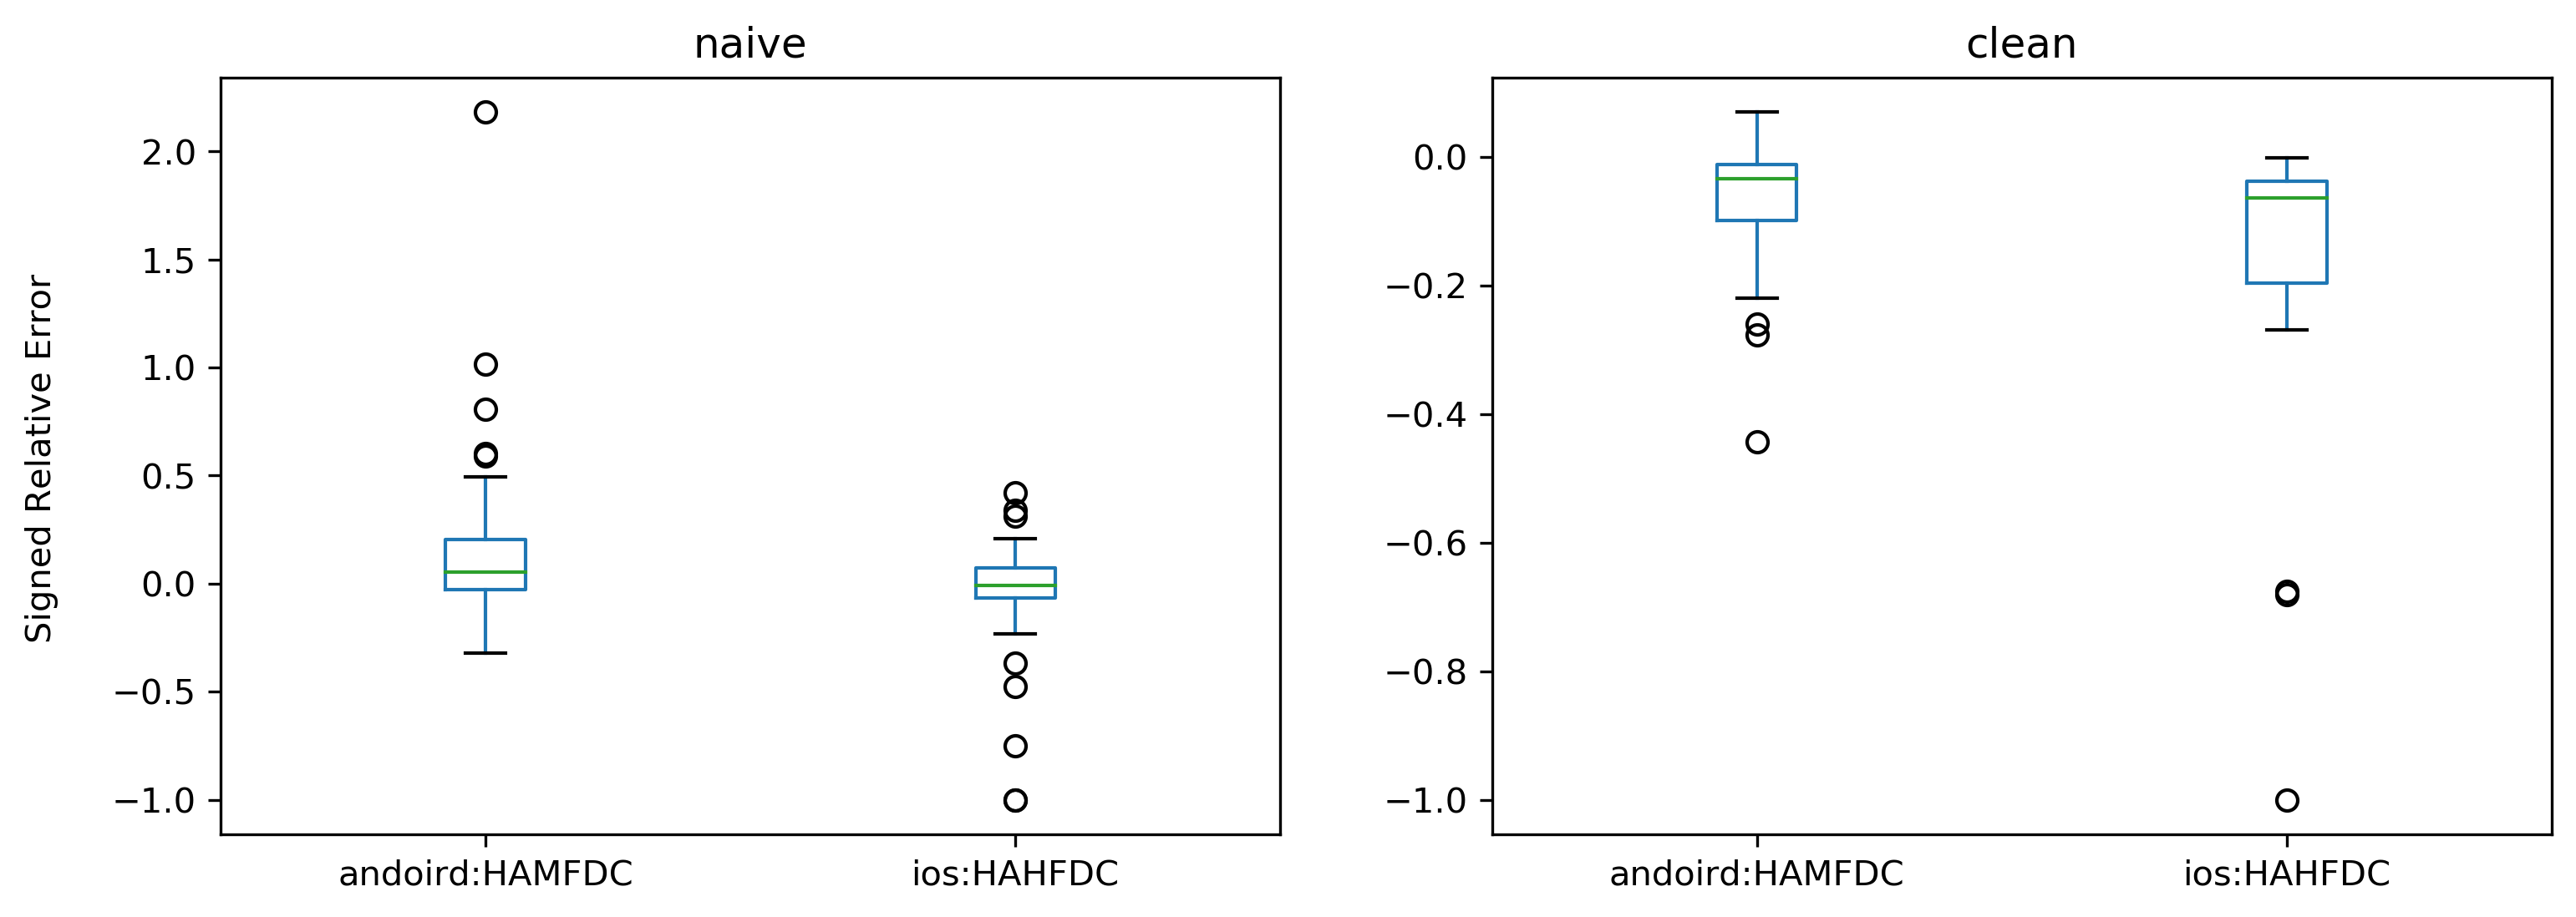

In [38]:
box_selected()

sensed dist 	 3622.682949062534
gt_dist 	 4166.48087694807
sensed dist 	 3401.033563758348
gt_dist 	 3575.1150980810125
sensed dist 	 232.29459102678564
gt_dist 	 4166.48087694807
sensed dist 	 3240.4132282062715
gt_dist 	 3575.1150980810125
sensed dist 	 4086.0969143635016
gt_dist 	 4166.48087694807
sensed dist 	 3014.9735699051703
gt_dist 	 3575.1150980810125
sensed dist 	 3622.682949062534
gt_dist 	 4166.48087694807
sensed dist 	 3401.033563758348
gt_dist 	 3575.1150980810125
sensed dist 	 232.29459102678564
gt_dist 	 4166.48087694807
sensed dist 	 3240.4132282062715
gt_dist 	 3575.1150980810125
sensed dist 	 4086.0969143635016
gt_dist 	 4166.48087694807
sensed dist 	 3014.9735699051703
gt_dist 	 3575.1150980810125
sensed dist 	 3622.682949062534
gt_dist 	 4166.48087694807
sensed dist 	 3401.033563758348
gt_dist 	 3575.1150980810125
sensed dist 	 232.29459102678564
gt_dist 	 4166.48087694807
sensed dist 	 3240.4132282062715
gt_dist 	 3575.1150980810125
sensed dist 	 4086.09691436350

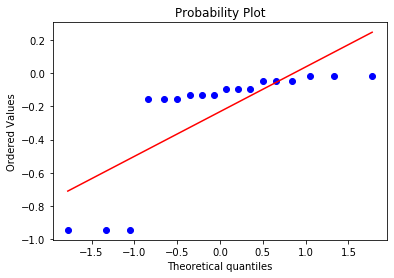

In [39]:
import numpy as np 
import pylab 
import scipy.stats as stats
measurements = np.random.normal(loc = 20, scale = 5, size=100)
a_err, r_err_ios = get_approx_err('ios', 'HAMFDC', [pv_la, pv_la, pv_la]); np.array(r_err_ios)
r = np.array(r_err_ios).flatten()
print(measurements.shape, r.shape)
stats.probplot(r, dist="norm", plot=pylab)
pylab.show()

In [40]:
measurements;
a_err, r_err_ios = get_approx_err('ios', 'HAMFDC', [av_la, av_sj, av_ucb]); np.array(r_err_ios)

sensed dist 	 3194.8884742511723
gt_dist 	 4166.48087694807
sensed dist 	 3255.1545958988327
gt_dist 	 3575.1150980810125
sensed dist 	 142.81924916129435
gt_dist 	 4166.48087694807
sensed dist 	 3233.7047883770024
gt_dist 	 3575.1150980810125
sensed dist 	 3211.6702886497974
gt_dist 	 4166.48087694807
sensed dist 	 3152.737977860821
gt_dist 	 3575.1150980810125
sensed dist 	 20889.849770984558
gt_dist 	 21897.56145035604
sensed dist 	 20910.154681505075
gt_dist 	 21743.642376215947
sensed dist 	 19716.58170232863
gt_dist 	 21897.56145035604
sensed dist 	 20619.926024572178
gt_dist 	 21743.642376215947
sensed dist 	 16019.31638205737
gt_dist 	 21897.56145035604
sensed dist 	 20941.35996867296
gt_dist 	 21743.642376215947
sensed dist 	 81620.16614269682
gt_dist 	 86033.02062489765
sensed dist 	 707.8006652449207
gt_dist 	 837.9847664440726
sensed dist 	 82555.814442197
gt_dist 	 84509.67456654109
sensed dist 	 80360.99705238681
gt_dist 	 86033.02062489765
sensed dist 	 866.8708668866533

array([[-0.23319257],
       [-0.08949656],
       [-0.96572185],
       [-0.09549631],
       [-0.22916476],
       [-0.11814364],
       [-0.04601936],
       [-0.03833248],
       [-0.09959921],
       [-0.05168023],
       [-0.26844291],
       [-0.03689733],
       [-0.05129257],
       [-0.15535378],
       [-0.02311996],
       [-0.06592845],
       [ 0.03447091],
       [-0.02983448],
       [-0.11777435],
       [-0.25225545],
       [-0.08361961],
       [-0.03976004],
       [-0.06900268],
       [-0.12571239],
       [-0.06907737],
       [-0.13881014],
       [-0.19382578],
       [-0.04455442],
       [-0.08888253],
       [-0.19765324]])

In [41]:
throw RuntimeException("Code below this does not work")

SyntaxError: invalid syntax (<ipython-input-41-91988c666edd>, line 1)


# investigate outlier

# JSON table 

In [ ]:
json_dump = json.dumps( 
    {
        "relative_distance_errors" :
        {
            "android:HAMF" : np.array(get_approx_err('android', 'HAMFDC', [av_la, av_sj, av_ucb])[-1]).tolist(),
            "ios:HAHF"     : np.array(get_approx_err('ios', 'HAHFDC', [av_la, av_sj, av_ucb])[-1]).tolist()
        }
    }
)
# Writing to relative_distance_errors.json
with open("relative_distance_errors.json", "w") as outfile:
    outfile.write(json_dump)